Lambda School Data Science

*Unit 4, Sprint 3, Module 3*

---

# Autoencoders

> An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner.[1][2] The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name. 

## Learning Objectives
*At the end of the lecture you should be to*:
* <a href="#p1">Part 1</a>: Describe the componenets of an autoencoder
* <a href="#p2">Part 2</a>: Train an autoencoder
* <a href="#p3">Part 3</a>: Apply an autoenocder to a basic information retrieval problem

__Problem:__ Is it possible to automatically represent an image as a fixed-sized vector even if it isn’t labeled?

__Solution:__ Use an autoencoder

Why do we need to represent an image as a fixed-sized vector do you ask? 

* __Information Retrieval__
    - [Reverse Image Search](https://en.wikipedia.org/wiki/Reverse_image_search)
    - [Recommendation Systems - Content Based Filtering](https://en.wikipedia.org/wiki/Recommender_system#Content-based_filtering)
* __Dimensionality Reduction__
    - [Feature Extraction](https://www.kaggle.com/c/vsb-power-line-fault-detection/discussion/78285)
    - [Manifold Learning](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction)

We've already seen *representation learning* when we talked about word embedding modelings during our NLP week. Today we're going to achieve a similiar goal on images using *autoencoders*. An autoencoder is a neural network that is trained to attempt to copy its input to its output. Usually they are restricted in ways that allow them to copy only approximately. The model often learns useful properties of the data, because it is forced to prioritize which aspecs of the input should be copied. The properties of autoencoders have made them an important part of modern generative modeling approaches. Consider autoencoders a special case of feed-forward networks (the kind we've been studying); backpropagation and gradient descent still work. 

# Autoencoder Architecture (Learn)
<a id="p1"></a>

## Overview

The *encoder* compresses the input data and the *decoder* does the reverse to produce the uncompressed version of the data to create a reconstruction of the input as accurately as possible:

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=800/>

The learning process gis described simply as minimizing a loss function: 
$ L(x, g(f(x))) $

- $L$ is a loss function penalizing $g(f(x))$ for being dissimiliar from $x$ (such as mean squared error)
- $f$ is the encoder function
- $g$ is the decoder function

## Follow Along
### Extremely Simple Autoencoder

In [1]:
import tensorflow as tf
import numpy as np
import os

URL_ = "https://github.com/LambdaSchool/DS-Unit-4-Sprint-2-Neural-Networks/blob/main/module4-Hyperparameter-Tuning/quickdraw10.npz?raw=true"

path_to_zip = tf.keras.utils.get_file('./quickdraw10.npz', origin=URL_, extract=False)

25427968/25421363 [==============================] - 1s 0us/step


In [2]:
data = np.load(path_to_zip)
x_train = data['arr_0']
y = data['arr_1']

print(x_train.shape)
print(y.shape)

(100000, 784)
(100000,)


In [3]:
class_names = ['apple',
 'anvil',
 'airplane',
 'banana',
 'The Eiffel Tower',
 'The Mona Lisa',
 'The Great Wall of China',
 'alarm clock',
 'ant',
 'asparagus']

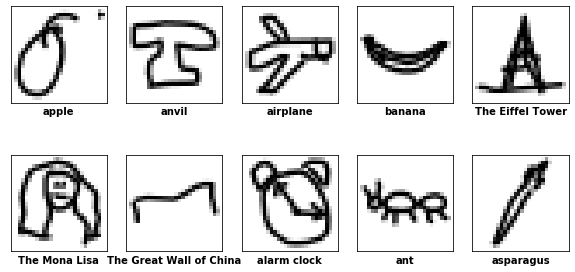

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
start = 0

for num, name in enumerate(class_names):
    plt.subplot(2,5, num+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[start].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(name)
    start += 10000
plt.show() 

In [6]:
from sklearn.utils import shuffle
x_train, y = shuffle(x_train, y)

In [7]:
y


array([4, 7, 6, ..., 0, 2, 7], dtype=int64)

In [8]:
x_train = x_train.astype('float32') / 255.
print(x_train.shape)

(100000, 784)


In [9]:
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.14901961, 0.2509804 , 0.34117648, 0.10980392, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00392157, 0.96862745, 1.        ,
       0.9882353 , 0.50980395, 0.        , 0.        , 0.     

In [10]:
%load_ext tensorboard

In [13]:
x_train[0].shape[0]

784

In [15]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(x_train[0].shape[0],))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(x_train[0].shape[0], activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [16]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [17]:
autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

In [18]:
import os
import datetime

from tensorflow.keras.callbacks import TensorBoard

stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)

logdir = os.path.join("logs", "simple_autoencoder")
tensorboard = TensorBoard(log_dir=logdir)

autoencoder.fit(x_train, 
                x_train, 
                epochs=100, 
                batch_size=64, 
                shuffle=True, # optinal because we shuffled the data earlier
                validation_split=0.2,
                callbacks=[stop, tensorboard]
                )

Epoch 1/100
   1/1250 [..............................] - ETA: 0s - loss: 0.6951WARNING:tensorflow:From c:\users\tigju\anaconda3\envs\datascience\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2932 - val_loss: 0.2428
Epoch 2/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2331 - val_loss: 0.2273
Epoch 3/100
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2255 - val_loss: 0.2241
Epoch 4/100
1250/1250 [==============================] - 6s 4ms/step - loss: 0.2236 - val_loss: 0.2230
Epoch 5/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2229 - val_loss: 0.2225
Epoch 6/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2225 - val_loss: 0.2222
Epoch 7/100
1250

In [21]:
%tensorboard --logdir=logs

Reusing TensorBoard on port 6006 (pid 13764), started 0:01:09 ago. (Use '!kill 13764' to kill it.)

In [20]:
# encode and decode some digits
# note that we take them from the *test* set

decoded_imgs = autoencoder(x_train)

In [22]:
class_names

['apple',
 'anvil',
 'airplane',
 'banana',
 'The Eiffel Tower',
 'The Mona Lisa',
 'The Great Wall of China',
 'alarm clock',
 'ant',
 'asparagus']

In [26]:
class_names[y[3]]

'The Great Wall of China'

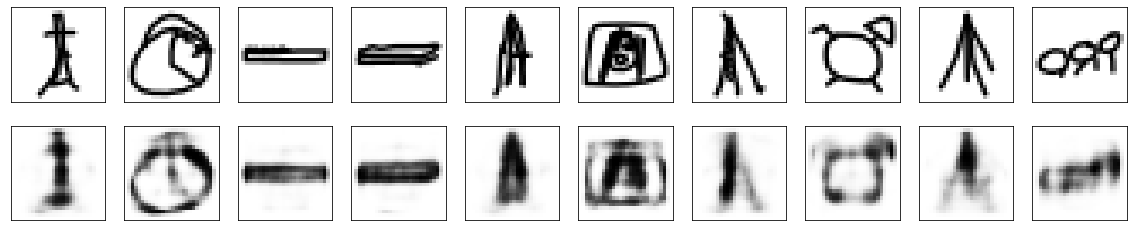

In [24]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap=plt.cm.binary)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].numpy().reshape(28, 28), cmap=plt.cm.binary)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Challenge

Expected to talk about the components of autoencoder and their purpose. 

# Train an Autoencoder (Learn)
<a id="p2"></a>

## Overview

As long as our architecture maintains an hourglass shape, we can continue to add layers and create a deeper network. 

## Follow Along

### Deep Autoencoder

In [27]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [28]:
# compile & fit model

autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)

logdir = os.path.join("logs", "deeper_autoencoder")
tensorboard = TensorBoard(log_dir=logdir)

autoencoder.fit(x_train, x_train,
                epochs=10000,
                batch_size=64,
                shuffle=True,
                validation_split=.2,
                callbacks=[stop,tensorboard])

Epoch 1/10000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2827 - val_loss: 0.2486
Epoch 2/10000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2403 - val_loss: 0.2317
Epoch 3/10000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2275 - val_loss: 0.2228
Epoch 4/10000
1250/1250 [==============================] - 9s 7ms/step - loss: 0.2208 - val_loss: 0.2181
Epoch 5/10000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2160 - val_loss: 0.2135
Epoch 6/10000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2118 - val_loss: 0.2097
Epoch 7/10000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2083 - val_loss: 0.2066
Epoch 8/10000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2056 - val_loss: 0.2049
Epoch 9/10000
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2036 - val_loss: 0.2029
Epoch 10/10000
1250/1250 [=============================

In [30]:
%tensorboard --logdir logs/deeper_autoencoder

Reusing TensorBoard on port 6006 (pid 33044), started 0:24:29 ago. (Use '!kill 33044' to kill it.)

In [33]:
decoded_imgs = autoencoder(x_train)

In [41]:
print(decoded_imgs.shape)
decoded_imgs 

(100000, 784)


<tf.Tensor: shape=(100000, 784), dtype=float32, numpy=
array([[8.58554663e-18, 1.81906612e-16, 4.83900327e-17, ...,
        4.01853818e-16, 2.47016380e-17, 1.48905163e-16],
       [2.42869041e-11, 5.32527598e-11, 3.11713225e-11, ...,
        3.68331310e-10, 8.50733164e-11, 1.32516456e-10],
       [2.09355984e-13, 1.17533533e-13, 1.35392669e-15, ...,
        1.12846066e-13, 8.42647553e-14, 1.35944959e-14],
       ...,
       [2.05350839e-14, 8.57261988e-14, 3.78515782e-14, ...,
        8.00572445e-14, 8.45916134e-15, 3.17351871e-14],
       [1.01879563e-08, 6.01890759e-09, 4.58188776e-09, ...,
        2.02352943e-08, 8.48046344e-09, 1.19741390e-08],
       [6.25385594e-12, 2.00808836e-12, 2.11267219e-11, ...,
        2.89493204e-11, 1.17544863e-11, 1.26316957e-10]], dtype=float32)>

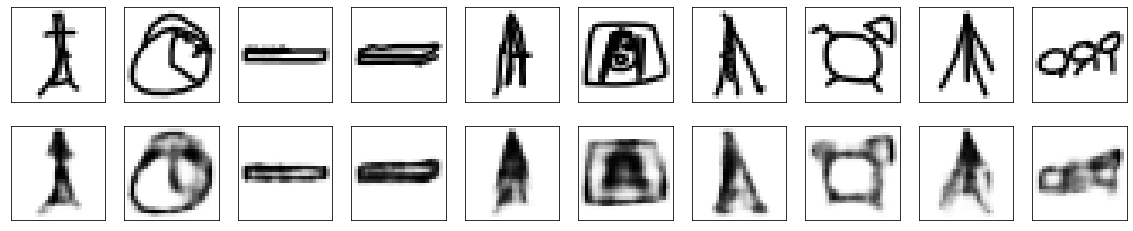

In [43]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap=plt.cm.binary)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].numpy().reshape(28, 28), cmap=plt.cm.binary)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Convolutional autoencoder

> Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

> Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model


n_channels = 1 # black&white images
# Create Model 
input_img = Input(shape=(28, 28, n_channels))
encoded = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2,2), padding='same')(encoded) 
encoded = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2,2), padding='same')(encoded) 
encoded = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2,2), padding='same')(encoded) # <-- dense vector representation i.e. embedding

decoded = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(8, (3,3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(16, (3,3), activation='relu')(decoded)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(n_channels, (3,3), activation='sigmoid', padding='same')(decoded)

autoencoder = Model(input_img, decoded)

autoencoder.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)          

In [44]:
x_train.shape

(100000, 784)

In [45]:
x_train = x_train.reshape((x_train.shape[0], 28, 28))
x_train.shape

(100000, 28, 28)

In [46]:
autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

In [47]:
stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)

logdir = os.path.join("logs", "conv_autoencoder")
tensorboard = TensorBoard(log_dir=logdir)

autoencoder.fit(x_train, x_train,
                epochs=10000,
                batch_size=64,
                shuffle=True,
                validation_split=.2,
                callbacks=[stop,tensorboard])

Epoch 1/10000
1250/1250 [==============================] - 10s 8ms/step - loss: 0.2704 - val_loss: 0.2383
Epoch 2/10000
1250/1250 [==============================] - 9s 7ms/step - loss: 0.2325 - val_loss: 0.2250
Epoch 3/10000
1250/1250 [==============================] - 9s 7ms/step - loss: 0.2224 - val_loss: 0.2174
Epoch 4/10000
1250/1250 [==============================] - 9s 7ms/step - loss: 0.2155 - val_loss: 0.2113
Epoch 5/10000
1250/1250 [==============================] - 9s 7ms/step - loss: 0.2102 - val_loss: 0.2068
Epoch 6/10000
1250/1250 [==============================] - 9s 7ms/step - loss: 0.2062 - val_loss: 0.2035
Epoch 7/10000
1250/1250 [==============================] - 9s 8ms/step - loss: 0.2030 - val_loss: 0.2009
Epoch 8/10000
1250/1250 [==============================] - 10s 8ms/step - loss: 0.2004 - val_loss: 0.1997
Epoch 9/10000
1250/1250 [==============================] - 9s 7ms/step - loss: 0.1982 - val_loss: 0.1964
Epoch 10/10000
1250/1250 [===========================

In [49]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 5952), started 0:00:52 ago. (Use '!kill 5952' to kill it.)

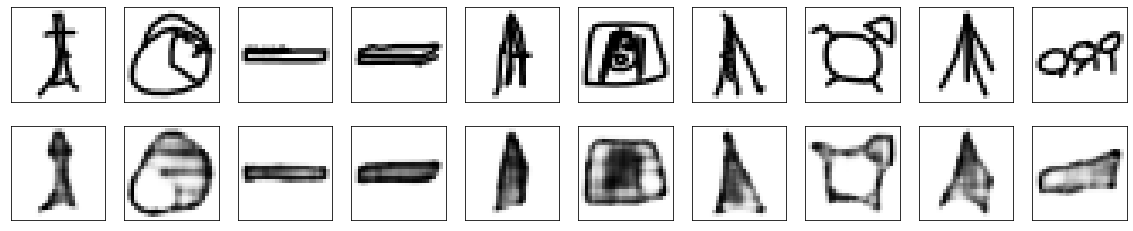

In [50]:
decoded_imgs = autoencoder.predict(x_train)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n +1)
    plt.imshow(decoded_imgs[i].reshape(28,28), cmap=plt.cm.binary)
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [51]:
class_names[y[2]]

'The Great Wall of China'

In [52]:
encoder = Model(input_img, encoded)

In [53]:
x_compressed = encoder.predict(x_train)

In [54]:
x_compressed = x_compressed.reshape((x_compressed.shape[0], 128))

In [55]:
x_compressed.shape

(100000, 128)

In [56]:
x_train[2].shape

(28, 28)

In [57]:
x_compressed[2].shape

(128,)

#### Visualization of the Representations

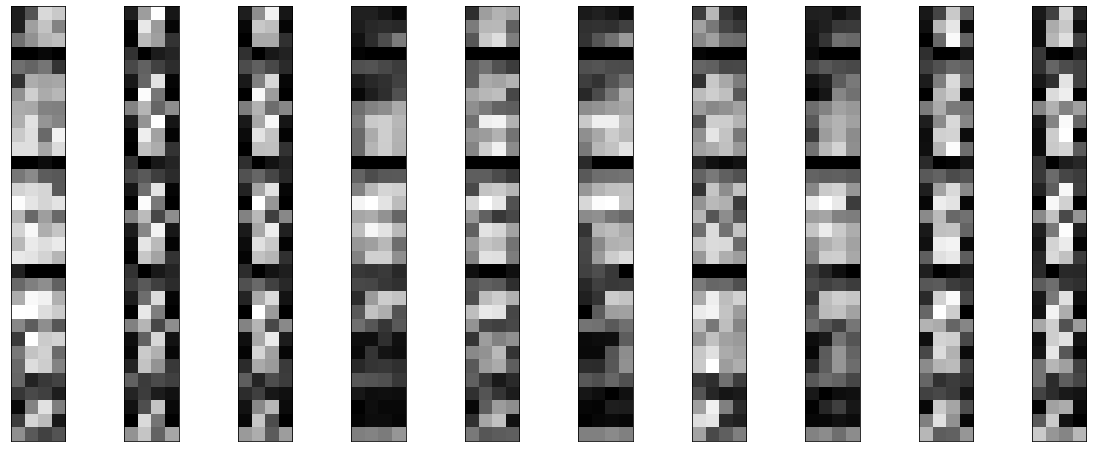

In [58]:
encoder = Model(input_img, encoded)
encoder.predict(x_train)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_compressed[i].reshape(4, 4 * 8  ).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Challenge

You will train an autoencoder at some point in the near future. 

# Information Retrieval with Autoencoders (Learn)
<a id="p3"></a>

## Overview

A common usecase for autoencoders is for reverse image search. Let's try to draw an image and see what's most similiar in our dataset. 

To accomplish this we will need to slice our autoendoer in half to extract our reduced features. :) 

## Follow Along

In [59]:
encoded_imgs = x_compressed

In [60]:
encoded_imgs.shape

(100000, 128)

In [61]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors()
nn.fit(encoded_imgs)

NearestNeighbors()

In [62]:
class_names

['apple',
 'anvil',
 'airplane',
 'banana',
 'The Eiffel Tower',
 'The Mona Lisa',
 'The Great Wall of China',
 'alarm clock',
 'ant',
 'asparagus']

In [ ]:
for i, l in enumerate(y):
  if l == 5:
    print(i)

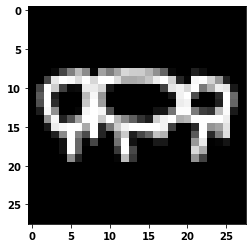

In [72]:
plt.imshow(x_train[98378])

In [73]:
class_names[y[98378]]

'ant'

In [74]:
x_train[98378].shape

(28, 28)

In [80]:
# (28, 28) --> (1, 28, 28, 1)

x = x_train[98378]
x = np.expand_dims(x, axis=0)
x = np.expand_dims(x, axis=-1)
x.shape

(1, 28, 28, 1)

In [81]:
pred = encoder.predict(x)
pred.shape

(1, 4, 4, 8)

In [82]:
preds = nn.kneighbors(pred.reshape(1,128))
preds[1]

array([[98378, 93377, 54784, 39382, 93923]], dtype=int64)

In [83]:
preds[1][0]

array([98378, 93377, 54784, 39382, 93923], dtype=int64)

ant
ant
ant
ant
ant


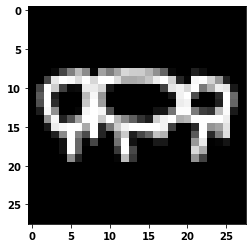

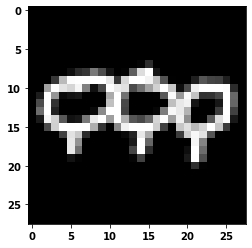

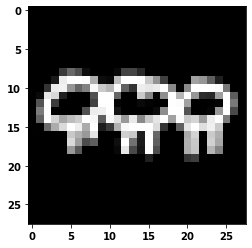

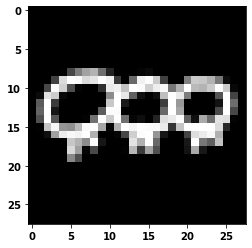

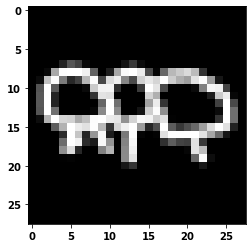

<Figure size 432x288 with 0 Axes>

In [84]:
n = 5

#plt.figure(figsize=(20,10))

for i in range(5):
  ind = preds[1][0][i]
  print(class_names[y[ind]])
  plt.imshow(x_train[ind])
  plt.figure()

## Challenge

You should already be familiar with KNN and similarity queries, so the key component of this section is know what to 'slice' from your autoencoder (the encoder) to extract features from your data. 

# Review

* <a href="#p1">Part 1</a>: Describe the componenets of an autoencoder
    - Enocder
    - Decoder
* <a href="#p2">Part 2</a>: Train an autoencoder
    - Can do in Keras Easily
    - Can use a variety of architectures
    - Architectures must follow hourglass shape
* <a href="#p3">Part 3</a>: Apply an autoenocder to a basic information retrieval problem
    - Extract just the encoder to use for various tasks
    - AE ares good for dimensionality reduction, reverse image search, and may more things. 


# Sources

__References__
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Deep Learning Cookbook](http://shop.oreilly.com/product/0636920097471.do)

__Additional Material__